# Coursework Part 2 - Dueling DQN

Dueling Deep Q-Networks were introduced as a completely novel approach compared to the state-of-the-art. Its utility lies primarily in the realm of model free RL. It separates two estimators: state value functions (action independent estimates of the value of a given state) and action advantage functions (which are state-dependent). These two streams are then combined in an aggregate layer to produce an estimation of the Q-values. 

This approach learns valuable states without examining the effect of the actions available in each state. This method is especially useful in states where actions do not affect the environment in any relevant way. It also has the added benefit of being easily combined with existing and future reinforcement learning algorithms.

The environment of choice for this network is the Cartpole (v-1) task obtained from the Open AI gym. The task involves the agent balancing a pole on a cart moving along a frictionless surface. The states correspond to the following parameters: 


1.   Cart Position
2.   Cart Velocity
3.   Pole Angle
4.   Velocity at the tip of the pole

The actions available for the agent include the application of a +1 or -1 force on the cart - to move it in the right and left directions respectively. 

A reward of +1 is awarded to the agent for every time step that it can keep the pole balanced.

An episode terminates when the pole's angle is greater than 15 degrees from the vertical, or if the cart's distance from the center exceeds 2.4 units. In this case, the agent will receive a reward of 0.

In [ ]:
# Load Drive and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch 
import random
import matplotlib.pyplot as plt

## Setting up Neural Network 

It is important to note here that the neural network architecture for the Dueling Deep Q-network differs from those for DQN and Double DQN. Here, our neural network provides estimates for state and action advantage values. These changes are shown in the initialisation of the DuelingDQN class below. The input layer and first two hidden layers will stay the same. However, the second hidden layer will decompose into the state (consisting of one node) and action advantage values (consisting of two nodes - one per action). These will later be aggregated when implementing training in the further sections below.  

In [ ]:
# creating network architecture
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class DuelingDQN(nn.Module):

  def __init__(self, lr, input_dims, hidden_dims, output_dims):
    super(DuelingDQN, self).__init__()
    self.fc1 = nn.Linear(input_dims, hidden_dims)
    self.fc2 = nn.Linear(hidden_dims, hidden_dims)
    self.V = nn.Linear(hidden_dims, 1)
    self.A = nn.Linear(hidden_dims, output_dims)

    self.optimizer = optim.SGD(self.parameters(), lr=lr)
    self.criterion = nn.MSELoss()
    self.activation = nn.ReLU()

  def forward(self, x):
    h1 = self.fc1(x)
    h1_activated = self.activation(h1)
    h2 = self.fc2(h1_activated)
    h2_activated = self.activation(h2)
    V = self.V(h2_activated)
    A = self.A(h2_activated)

    return V, A

## Setting up Experience Replay

Experience replay involves storing transitions within an environment in a memory. Neural networks are generally constructed on independent and identically distributed data. Given the sequential nature of an agent's navigation through an environment, some tweaks will be required to ensure our i.i.d assumption holds. Whilst these changes may not guarantee the assumption completely, they offer a working solution. 

The process works by building a store of memory, consisting of an agent's transitions through an environment. A transition can be represented by the tuple (state, reward, action, next_state). Once a store of sufficient memories has been collected, the agent can randomly sample batches from this store to feed as input to the Q-network. This random/uniform sampling reduces the correlation between samples.

The "ReplayMemory" class below is constructed based on the topics discussed above. It consists of a memory capacity (the size of its memory), and the memory store itself. The methods in this class include:



*   store_transition: This method will store a transition into memory. It makes use of a private method named _convert_to_tensor which converts transitions into PyTorch tensors to facilitate compatability with the neural network architecture.
*   sample_memory: This method will sample a batch of transitions from memory and return these batches in a format compatabile for input to the neural network.



In [ ]:
# creating a class for experience replay
class ReplayMemory():
  def __init__(self, memory_cap):
    self.memory_capacity = memory_cap
    self.memory = []
    self.current_memory_pos = 0

  def store_transition(self, state, action, reward, next_state):
    if len(self.memory) < self.memory_capacity:
      self.memory.append(None)

    state_tensor, action_tensor, reward_tensor, next_state_tensor = self._convert_to_tensor(state, action, reward, next_state)
    self.memory[self.current_memory_pos] = (state_tensor, action_tensor, reward_tensor, next_state_tensor)
    self.current_memory_pos = (self.current_memory_pos + 1) % self.memory_capacity

  def sample_memory(self, batch_size):
    memory_batch = random.sample(self.memory, batch_size)
    state_batch = []
    action_batch = []
    reward_batch = []
    next_state_batch = []

    for item in memory_batch:
      state_batch.append(item[0])
      action_batch.append(item[1])
      reward_batch.append(item[2])
      next_state_batch.append(item[3])
    
    state_batch_tensor = torch.cat(state_batch)
    action_batch_tensor = torch.cat(action_batch)
    reward_batch_tensor = torch.cat(reward_batch)
    next_state_batch_tensor = torch.cat(next_state_batch)

    return memory_batch, state_batch_tensor, action_batch_tensor, reward_batch_tensor, next_state_batch_tensor

  def _convert_to_tensor(self, state, action, reward, next_state):
    s = torch.tensor([state], dtype=torch.float, device=device)
    a = torch.tensor([[action]], device=device)
    r = torch.tensor([[reward]], device=device)
    s_new = torch.tensor([next_state], dtype=torch.float, device=device)

    return s,a,r,s_new

## Setting up Agent

The agent class below brings all the pieces together. It will be instantiated by creating an evaluation and target Q-network, as well as a memory using the classes defined above. The class architecture will also include methods to control our agent's actions and learning. All methods are shown below:

*   Epsilon_greedy_action: Implement an Epsilon greedy policy that will drive an agent's selection of actions
*   store_transition: Store a transition into memory using the ReplayMemory class explained above
*   fill_memory: Fill agent's memory upto capacity
*   sample_memory: Implement the sample_memory method from the ReplayMemory class
*   reduce_epsilon: Reduce epsilon until it reaches a minimum values specified during class instantiation
*   implement_learning: This method is where the majority of the agent's learning will take place. Batches will be drawn from memory and fed as input into the agent's Q-network defined during instantiation. It is important to note here that non-final states will not be considered for action selection - given that there are no actions available once the terminal state has been reached. Additionally, the state and action advantage values returned by our respective networks will have to be aggregated in order to approximate the Q-values. This is done using the Pytorch "add" function. Please note here that these values cannot simply be added together. This will lead to the issue of identifiability - where there exist no unique solutions to the equation. Therefore, the combination of the state and advantage values will need to include an average over the the advantage values of the next state in order to ensure a closed solution. Once completed, the traditional methods of action selection and evaluation can proceed. 

In [ ]:
class Agent():
  def __init__(self, lr, gamma, epsilon, input_dims, hidden_dims, output_dims, memory_capacity, batch_size, min_epsilon, decay):
    self.lr = lr
    self.gamma = gamma
    self.epsilon = epsilon
    self.lr = lr
    self.input_dims = input_dims
    self.hidden_dims = hidden_dims
    self.output_dims = output_dims
    self.memory_capacity = memory_capacity
    self.batch_size = batch_size
    self.min_epsilon = min_epsilon
    self.decay = decay
    self.action_space = [0, 1]
    self.loss = None

    # Initialising memory
    self.memory = ReplayMemory(self.memory_capacity)

    # Initialising Q networks
    self.Qnet = DuelingDQN(lr = self.lr, input_dims = self.input_dims, hidden_dims = self.hidden_dims, output_dims = self.output_dims).to(device)
    self.Qtarget = DuelingDQN(lr = self.lr, input_dims = self.input_dims, hidden_dims = self.hidden_dims, output_dims = self.output_dims).to(device)

  def Epsilon_greedy_action(self, obs):
    # pick an action 
    if np.random.random() > self.epsilon:
      with torch.no_grad():
        self.Qnet.eval()  
        state = torch.tensor(obs, dtype=torch.float, device=device)
        v, a = self.Qnet.forward(state)
        action = torch.argmax(a).item()
        self.Qnet.train()
    else:
      action = np.random.choice(self.action_space)

    return action

  def store_transition(self, state, action, reward, nxt_state):
    self.memory.store_transition(state, action, reward, nxt_state)

  def fill_memory(self):
    # Filling memory 
    memory_full = False
    _env = gym.make('CartPole-v1')
    while memory_full == False:
      obs = _env.reset()
      done = False
      while done == False:
        # pick an action 
        action = self.Epsilon_greedy_action(obs)
        nxt_obs, reward, done, info = _env.step(action) # Interacting with environment
        if done:
          nxt_obs = [-100,-100,-100,-100]
        # Store transitions in memory
        self.store_transition(obs, action, reward, nxt_obs)
        obs = nxt_obs
        if len(self.memory.memory) == self.memory_capacity:
          memory_full = True
    print("memory filled")

  def sample_memory(self):
    memory_batch, state_batch_tensor, action_batch_tensor, reward_batch_tensor, next_state_batch_tensor = self.memory.sample_memory(self.batch_size)
    return state_batch_tensor, action_batch_tensor, reward_batch_tensor, next_state_batch_tensor

  def reduce_epsilon(self):
    if self.epsilon > self.min_epsilon:
      self.epsilon = self.epsilon * self.decay
    else:
      self.epsilon = self.min_epsilon

  def implement_learning(self):

    state_batch, action_batch, reward_batch, next_state_batch = self.sample_memory()
    non_final_state_b = torch.tensor(tuple(map(lambda s: s[0] != -100, next_state_batch)), device=device)
    non_final_nxt_states = next_state_batch[non_final_state_b]

    V_q_pred, A_q_pred = self.Qnet.forward(state_batch)
    q_pred = torch.add(V_q_pred, A_q_pred - A_q_pred.mean(dim=1, keepdim=True)).gather(1, action_batch)

    q_next = torch.zeros(self.batch_size, device=device)
    V_q_t, A_q_t = self.Qtarget.forward(non_final_nxt_states)
    q_next[non_final_state_b] = torch.add(V_q_t, A_q_t - A_q_t.mean(dim=1, keepdim=True)).max(1)[0].detach()
    q_next = q_next.unsqueeze(1)
    q_target = (q_next * self.gamma) + reward_batch
    loss = self.Qnet.criterion(q_pred, q_target)
    self.Qnet.optimizer.zero_grad()
    loss.backward()

    for param in self.Qnet.parameters():
      param.grad.data.clamp_(-1,1)

    self.Qnet.optimizer.step()

## Basic Training

The agent is now ready to begin learning. To begin with, a basic training run will be conducted on pre-defined hyperparameters in order to faciliate comparison with Vanilla DQN and Double DQN. Hyperparameter optimisation will be conducted in the next section below.

The training begins instantiating the agent with the requisite hyperparameters. Its memory will first be filled and then interaction with the environment can begin. Results from these interactions will be stored as memories. After which, the implement_learning method in the agent class will be called - which will conduct training on the Q-networks created - with results being stored. 

Finally, the parameters of the target Q-network will be updated with the evaluation network's parameters every 20 time-steps.

In [ ]:
num_episodes = 10000
lr = 0.001
gamma = 0.9
eps = 1
input_dims = 4
hidden_dims = 8
output_dims = 2
mem_capacity = 20000
batch_size = 200
min_eps = 0.01
decay = 0.9999


agent = Agent(lr=lr, gamma=gamma, epsilon=eps, input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims, memory_capacity=mem_capacity, batch_size=batch_size,  min_epsilon=min_eps, decay=decay)
agent.Qtarget.load_state_dict(agent.Qnet.state_dict())
agent.Qtarget.eval()
agent.fill_memory()
env = gym.make('CartPole-v1')
scores = list()
for i in range(num_episodes):
  obs = env.reset()
  done = False
  score = 0
  while done == False:
    # pick an action 
    action = agent.Epsilon_greedy_action(obs)
    # interacting with environment
    nxt_obs, reward, done, info = env.step(action) 
    if done:
      nxt_obs = [-100,-100,-100,-100]
    agent.store_transition(obs, action, reward, nxt_obs)
    obs = nxt_obs
    score += reward
    l = agent.implement_learning()      
  agent.reduce_epsilon()
  scores.append(score)
  if i%20 == 0:
    agent.Qtarget.load_state_dict(agent.Qnet.state_dict())
  if i % 100 == 0:
    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'avg score %.1f' % (avg_score))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


memory filled
episode  0 avg score 14.0
episode  100 avg score 22.0
episode  200 avg score 20.1
episode  300 avg score 23.8
episode  400 avg score 25.0
episode  500 avg score 26.5
episode  600 avg score 24.1
episode  700 avg score 26.7
episode  800 avg score 27.1
episode  900 avg score 24.0
episode  1000 avg score 24.9
episode  1100 avg score 27.8
episode  1200 avg score 28.8
episode  1300 avg score 24.1
episode  1400 avg score 30.5
episode  1500 avg score 32.7
episode  1600 avg score 32.3
episode  1700 avg score 31.8
episode  1800 avg score 31.0
episode  1900 avg score 34.3
episode  2000 avg score 32.0
episode  2100 avg score 41.8
episode  2200 avg score 38.2
episode  2300 avg score 36.4
episode  2400 avg score 36.8
episode  2500 avg score 41.7
episode  2600 avg score 43.4
episode  2700 avg score 43.2
episode  2800 avg score 38.5
episode  2900 avg score 46.5
episode  3000 avg score 49.1
episode  3100 avg score 47.6
episode  3200 avg score 50.4
episode  3300 avg score 50.6
episode  340

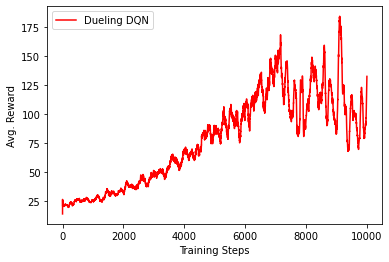

In [ ]:
# plotting results
x = [i for i in range(num_episodes)]
N = len(scores)
running_avg = np.empty(N)
for t in range(N):
  running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])
plt.plot(x, running_avg, label="Dueling DQN", color="r")
plt.ylabel('Avg. Reward')
plt.xlabel("Training Steps")
plt.legend(loc="upper left")
plt.show() 

## Hyperparameter Tuning

Hyperparameter tuning will be performed on the learning rate and gamma. The values tested will correspond to 0.01 and 0.0001 for the learning rate and 0.8 and 1.0 for gamma. 

The learning rate controls the extent to which our model adapts to new information. Higher rates correspond to less training time, but the model may converge to a suboptimal solution. For lower rates, training progresses slower as limited updates are being made to the weights of the neural network.

Gamma, or, the discount factor is utilised to discount future rewards. If the agent is only concerned with immediate rewards (lower gamma), it is termed "myopic". If all rewards are given equal value (higher gamma), it is termed "far-sighted". 

Hyperparameter tuning will be implemented using nested for loops. Results from each loop will be stored and then plotted for evaluation.

In [ ]:
num_episodes = 10000
learning_rates = [0.0001, 0.01] 
gammas = [0.8, 1.0]
eps = 1
input_dims = 4
hidden_dims = 8
output_dims = 2
mem_capacity = 20000
batch_size = 200
min_eps = 0.01
decay = 0.9999
scores_gathered = list()

for lr in learning_rates:
    for gamma in gammas:
      agent = Agent(lr=lr, gamma=gamma, epsilon=eps, input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims, memory_capacity=mem_capacity, batch_size=batch_size,  min_epsilon=min_eps, decay=decay)
      agent.Qtarget.load_state_dict(agent.Qnet.state_dict())
      agent.Qtarget.eval()
      agent.fill_memory()
      env = gym.make('CartPole-v1')
      scores = list()
      for i in range(num_episodes):
        obs = env.reset()
        done = False
        score = 0
        while done == False:
          # pick an action 
          action = agent.Epsilon_greedy_action(obs)
          # interacting with environment
          nxt_obs, reward, done, info = env.step(action) 
          if done:
            nxt_obs = [-100,-100,-100,-100]
          agent.store_transition(obs, action, reward, nxt_obs)
          obs = nxt_obs
          score += reward
          l = agent.implement_learning()      
        agent.reduce_epsilon()
        scores.append(score)
        if i%20 == 0:
          agent.Qtarget.load_state_dict(agent.Qnet.state_dict())
        if i % 100 == 0:
          avg_score = np.mean(scores[-100:])
          print('episode ', i, 'avg score %.1f' % (avg_score))
      scores_gathered.append(scores)

memory filled
episode  0 avg score 27.0
episode  100 avg score 22.1
episode  200 avg score 22.5
episode  300 avg score 21.4
episode  400 avg score 24.4
episode  500 avg score 21.9
episode  600 avg score 21.5
episode  700 avg score 24.1
episode  800 avg score 22.5
episode  900 avg score 20.0
episode  1000 avg score 19.8
episode  1100 avg score 21.3
episode  1200 avg score 19.7
episode  1300 avg score 20.6
episode  1400 avg score 22.0
episode  1500 avg score 21.1
episode  1600 avg score 19.9
episode  1700 avg score 19.0
episode  1800 avg score 20.2
episode  1900 avg score 19.9
episode  2000 avg score 18.9
episode  2100 avg score 18.7
episode  2200 avg score 19.3
episode  2300 avg score 19.7
episode  2400 avg score 23.3
episode  2500 avg score 23.7
episode  2600 avg score 24.0
episode  2700 avg score 22.5
episode  2800 avg score 19.9
episode  2900 avg score 19.9
episode  3000 avg score 20.1
episode  3100 avg score 23.5
episode  3200 avg score 25.0
episode  3300 avg score 22.0
episode  340

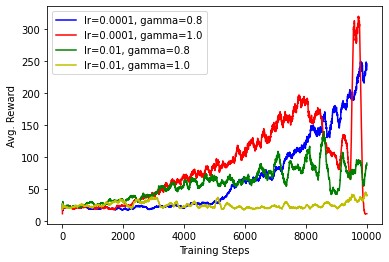

In [ ]:
x = [i for i in range(num_episodes)]
colors = ['b', 'r', 'g', 'y']
labels = ["lr=0.0001, gamma=0.8", "lr=0.0001, gamma=1.0", "lr=0.01, gamma=0.8", "lr=0.01, gamma=1.0"]
i = 0
for scores in scores_gathered:
  N = len(scores)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])
  plt.plot(x, running_avg, color=colors[i], label=labels[i])
  i += 1

plt.ylabel('Avg. Reward')
plt.xlabel("Training Steps")
plt.legend(loc="upper left")
plt.show()